In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
import gc

train = pd.read_csv("new.csv")

In [2]:
train.head(10)

,series_id,step,timestamp,anglez,enmo,awake
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217,1
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215,1
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216,1
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213,1
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215,1
5,038441c925bb,5,2018-08-14T15:30:25-0400,2.6367,0.0217,1
6,038441c925bb,6,2018-08-14T15:30:30-0400,2.6367,0.0217,1
7,038441c925bb,7,2018-08-14T15:30:35-0400,2.6367,0.0218,1
8,038441c925bb,8,2018-08-14T15:30:40-0400,2.7980,0.0223,1
9,038441c925bb,9,2018-08-14T15:30:45-0400,3.0847,0.0217,1


In [3]:
def make_features(df):
    # parse the timestamp and create an "hour" feature
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["hour"] = df["timestamp"].dt.hour
    
    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    
    return df

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

In [4]:
train   = make_features(train)

X_train = train[features]
y_train = train["awake"]

# save some memory
# del train
# gc.collect();

/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3406697520.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3406697520.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3406697520.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffi

In [14]:
print(y_train.tail(40))

10892    0
10893    0
10894    0
10895    0
10896    0
10897    0
10898    0
10899    0
10900    0
10901    0
10902    0
10903    0
10904    0
10905    0
10906    0
10907    0
10908    0
10909    0
10910    0
10911    0
10912    0
10913    0
10914    0
10915    0
10916    0
10917    0
10918    0
10919    0
10920    0
10921    0
10922    0
10923    0
10924    0
10925    0
10926    0
10927    0
10928    0
10929    0
10930    0
10931    0
Name: awake, dtype: int64


In [5]:
X_train.shape, y_train.shape

((10932, 15), (10932,))

In [6]:
%%time

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=50,
                                    min_samples_leaf=300,
                                    random_state=42,n_jobs=-1)

classifier.fit(X_train, y_train)

# save some memory
# del X_train, y_train
# gc.collect();

CPU times: user 1.18 s, sys: 308 ms, total: 1.49 s
Wall time: 11.8 s


RandomForestClassifier(min_samples_leaf=300, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [45]:
# test  = pd.read_parquet("data/child-mind-institute-detect-sleep-states/test_series.parquet")
test  = pd.read_csv("new_test.csv")

test  = make_features(test)

X_test = test[features]

test["not_awake"] = classifier.predict_proba(X_test)[:,0]
test["awake"]     = classifier.predict_proba(X_test)[:,1]


/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3406697520.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3406697520.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3406697520.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffi

In [47]:
print(test[["not_awake", "awake"]].count)

<bound method DataFrame.count of       not_awake     awake
0      0.470420  0.529580
1      0.472875  0.527125
2      0.478537  0.521463
3      0.478537  0.521463
4      0.470420  0.529580
...         ...       ...
9995   0.568383  0.431617
9996   0.568383  0.431617
9997   0.566631  0.433369
9998   0.485314  0.514686
9999   0.485314  0.514686

[10000 rows x 2 columns]>


In [48]:
b1 = test[['not_awake', 'awake', 'score', 'smooth', 'event']]
b1.to_csv("trash01.csv")

In [78]:
# smoothing the predictions
smoothing_length = 700
test["score"]  = test["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
test["smooth"] = test["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
# re-binarize
test["smooth"] = test["smooth"].round()

# https://stackoverflow.com/questions/73777727/how-to-mark-start-end-of-a-series-of-non-null-and-non-0-values-in-a-column-of-a
def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(lstCV, lambda cv: 
                            (cv[0], cv[1]!=0 and not pd.isnull(cv[1]))):
        llg = sum(1 for item in g)
        if v is False: 
            lstPOI.extend([0]*llg)
        else: 
            lstPOI.extend(['onset']+(llg-2)*[0]+['wakeup'] if llg > 1 else [0])
    return lstPOI

test["event"] = get_event(test)

/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3334547271.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test["score"]  = test["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
/var/folders/lg/70n18mwd1fq0_3cf41_k63th0000gn/T/ipykernel_16817/3334547271.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test["smooth"] = test["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")


In [49]:
sample_submission = test.loc[test["event"] != 0][["series_id","step","event","score"]].copy().reset_index(drop=True).reset_index(names="row_id")
sample_submission.to_csv('submission.csv', index=False)

In [66]:
print(test.head())

   Unnamed: 0     series_id    step                 timestamp   anglez  \
0           0  038441c925bb  245324 2018-08-29 00:13:40+00:00  81.6900   
1           1  038441c925bb  245325 2018-08-29 00:13:45+00:00  68.0817   
2           2  038441c925bb  245326 2018-08-29 00:13:50+00:00  44.0422   
3           3  038441c925bb  245327 2018-08-29 00:13:55+00:00  58.1264   
4           4  038441c925bb  245328 2018-08-29 00:14:00+00:00  81.2307   

     enmo  hour  anglez_diff  enmo_diff  anglez_rolling_mean  ...  \
0  0.0000     0      -56.875   0.065125               70.125  ...   
1  0.0084     0      -56.875   0.065125               70.125  ...   
2  0.0146     0      -56.875   0.065125               70.125  ...   
3  0.0130     0      -56.875   0.065125               70.125  ...   
4  0.0001     0      -56.875   0.065125               70.125  ...   

   enmo_rolling_std  anglez_diff_rolling_mean  enmo_diff_rolling_mean  \
0          0.010193                   -56.875                0.0651

In [53]:
import matplotlib.pyplot as plt

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

sample_num = train.shape[0]

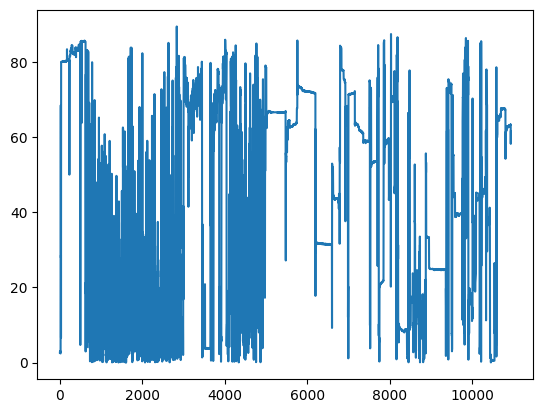

In [62]:
plt.plot(range(sample_num), train["anglez"])
plt.show()

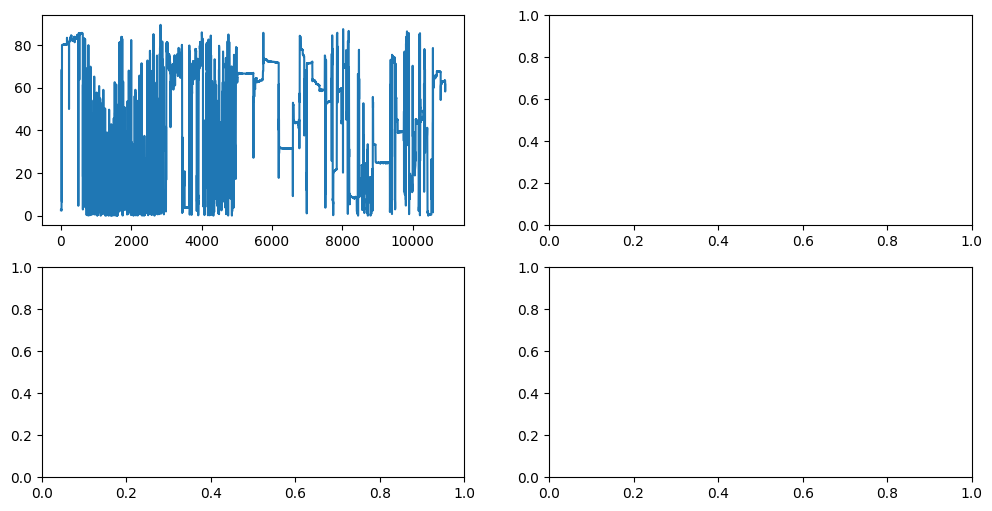

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
ax[0,0].plot(range(sample_num), train[["anglez"]])

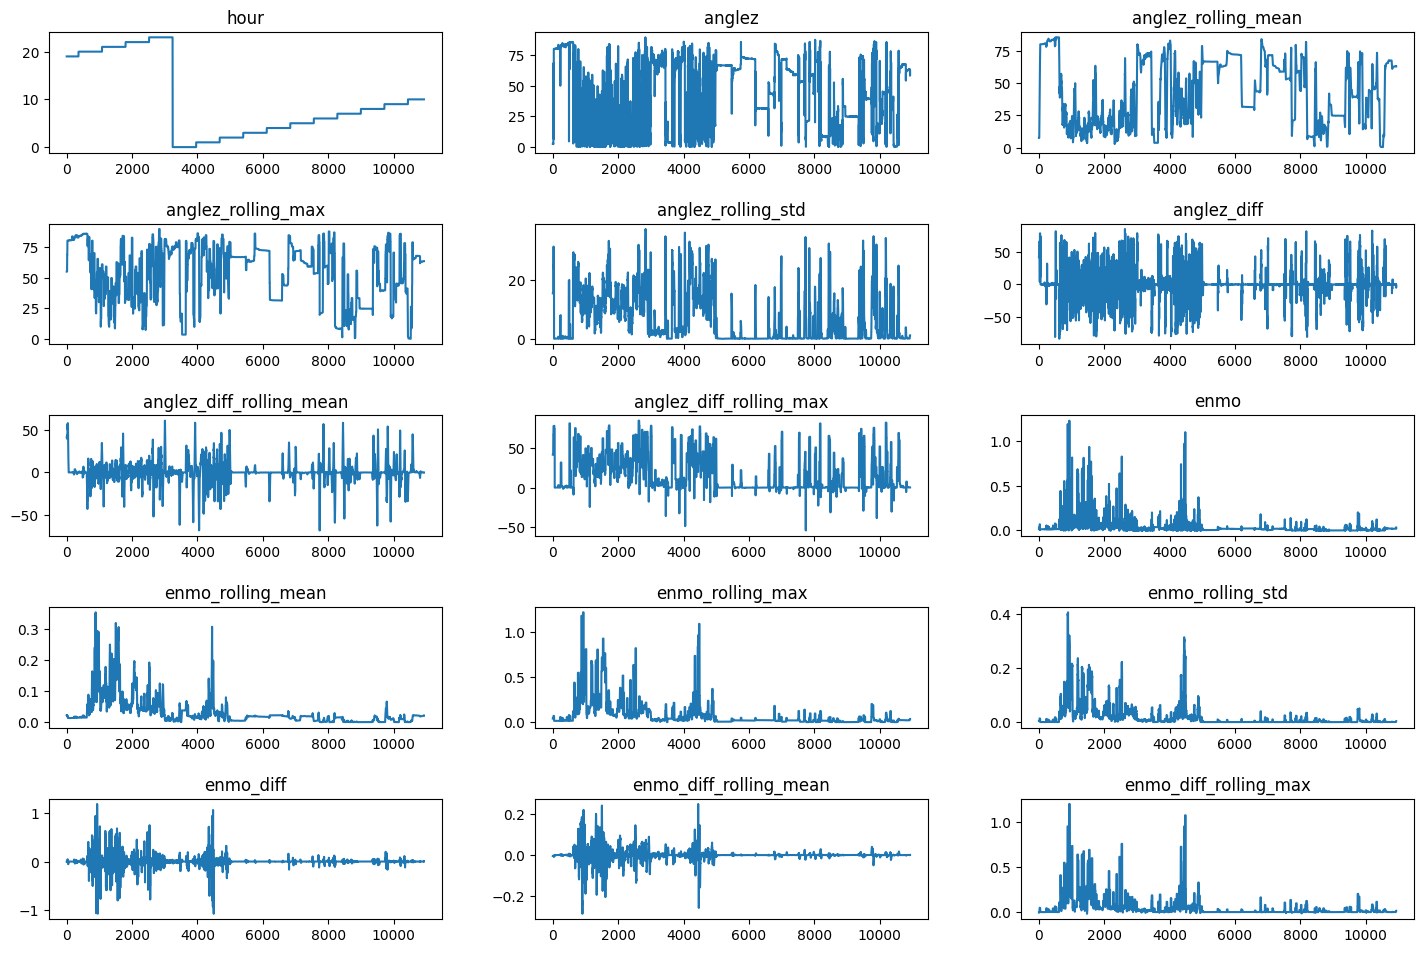

In [64]:
import matplotlib.pyplot as plt

# Danh sách các tính năng
features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

sample_num = train.shape[0]

# Tạo subplot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)  # Để tránh trùng lấn giữa các subplot

# Lặp qua danh sách các tính năng và vẽ chúng
for i, feature in enumerate(features):
    row = i // 3  # Xác định hàng cho subplot
    col = i % 3   # Xác định cột cho subplot
    ax = axes[row, col]  # Lấy subplot tại vị trí hàng và cột

    # Vẽ tính năng hiện tại
    ax.plot(range(sample_num), train[feature])
    ax.set_title(feature)  # Đặt tiêu đề cho subplot

plt.show()

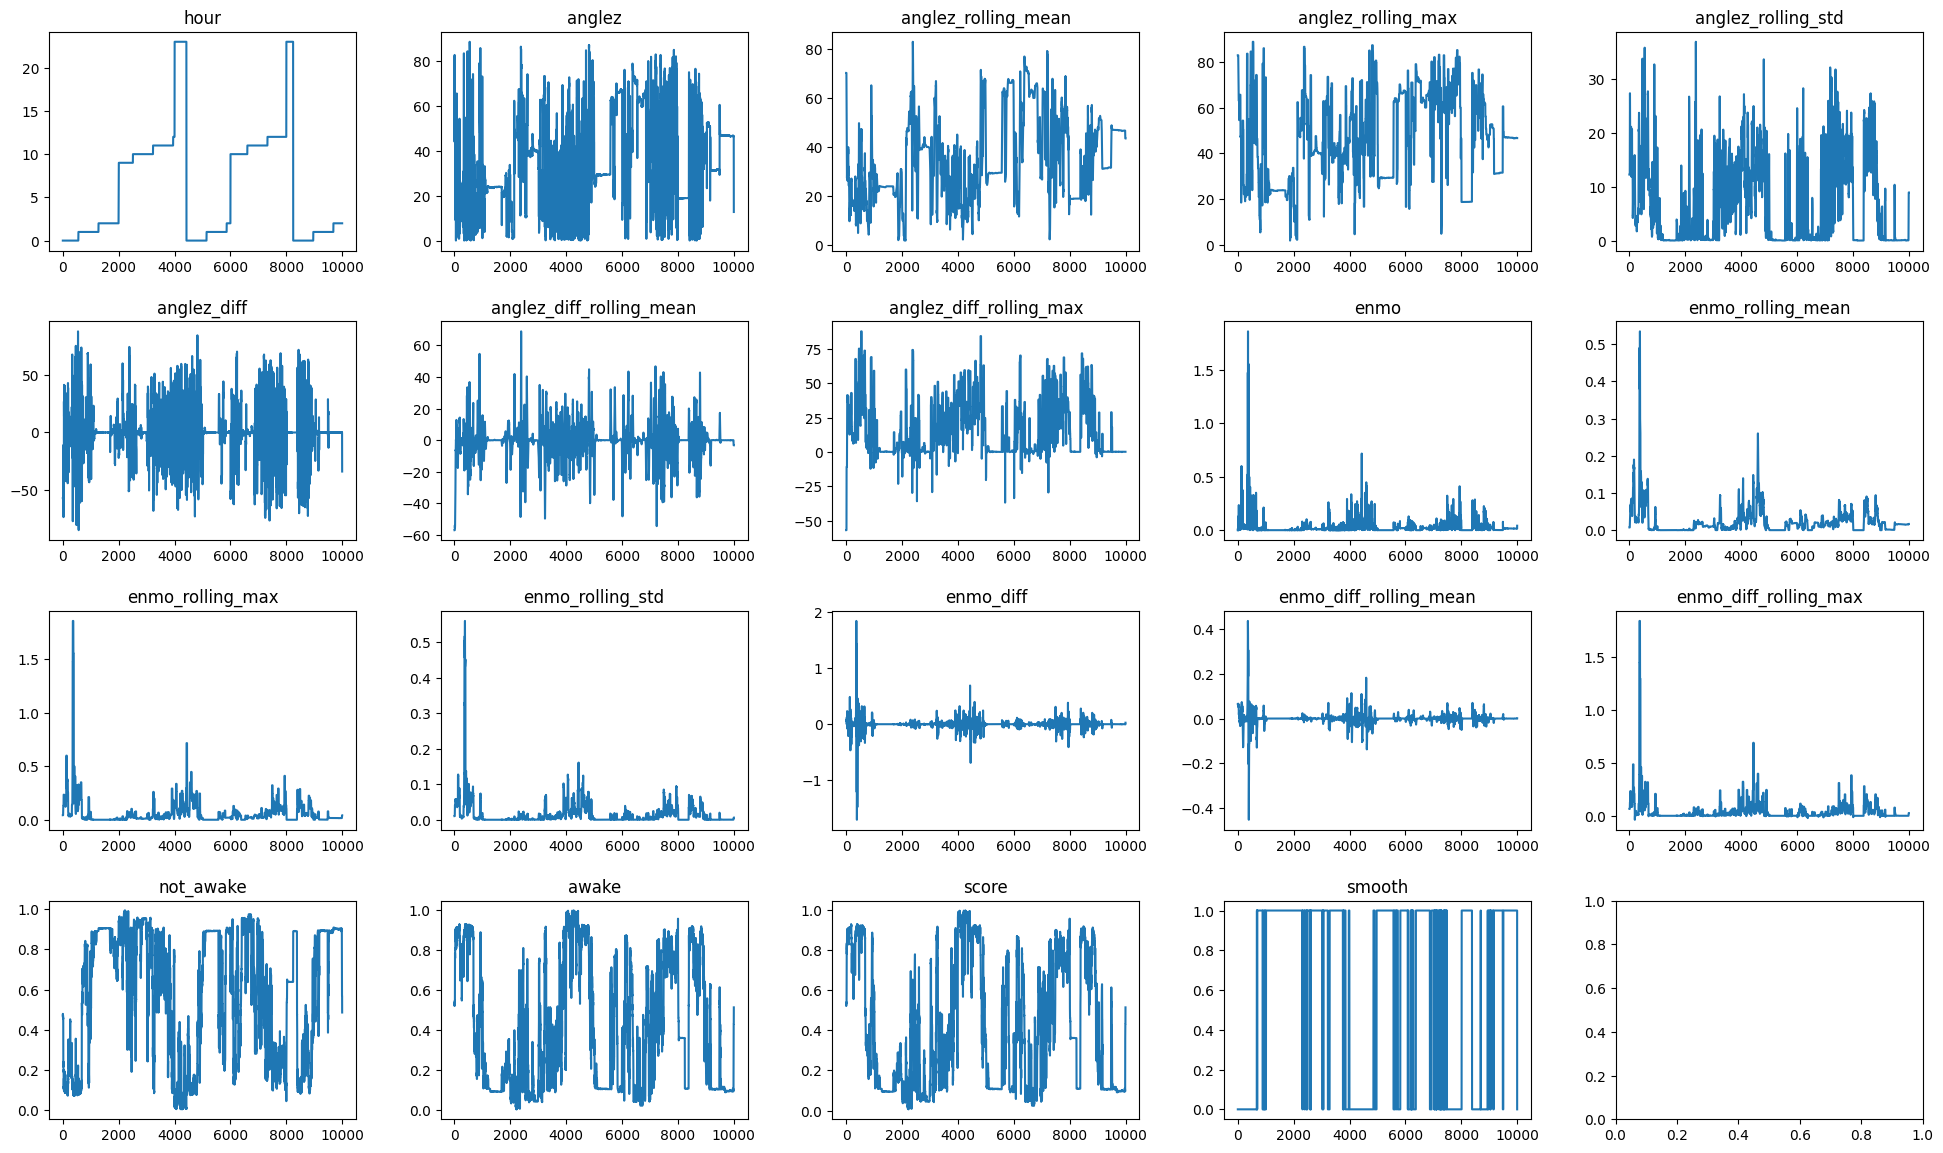

In [71]:
# Danh sách các tính năng
features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
            "not_awake",
            "awake",
            "score",
            "smooth"
           ]

sample_num = test.shape[0]

# Tạo subplot
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
fig.tight_layout(pad=3.0)  # Để tránh trùng lấn giữa các subplot

# Lặp qua danh sách các tính năng và vẽ chúng
for i, feature in enumerate(features):
    row = i // 5  # Xác định hàng cho subplot
    col = i % 5   # Xác định cột cho subplot
    ax = axes[row, col]  # Lấy subplot tại vị trí hàng và cột

    # Vẽ tính năng hiện tại
    ax.plot(range(sample_num), test[feature])
    ax.set_title(feature)  # Đặt tiêu đề cho subplot

plt.show()

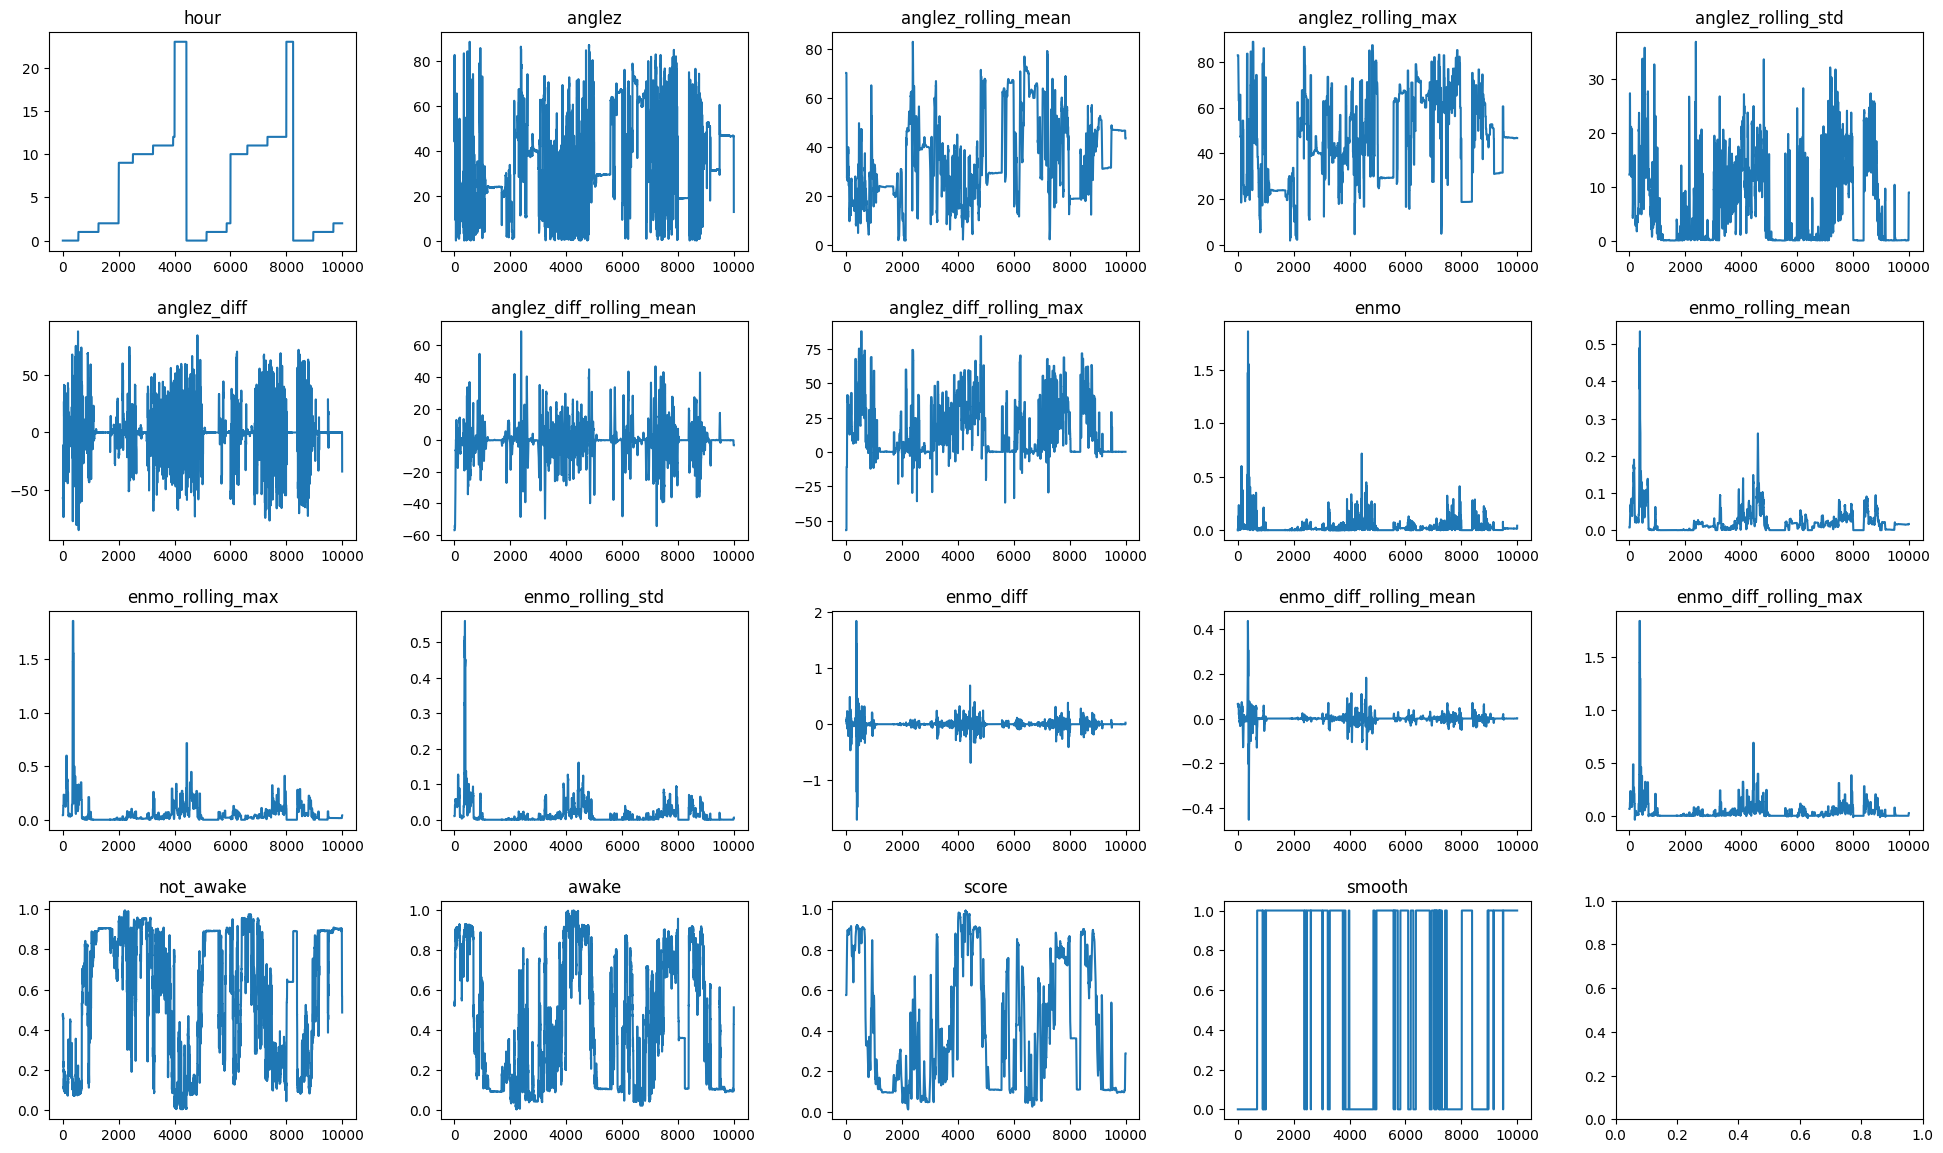

In [73]:
# Danh sách các tính năng
features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
            "not_awake",
            "awake",
            "score",
            "smooth"
           ]

sample_num = test.shape[0]

# Tạo subplot
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
fig.tight_layout(pad=3.0)  # Để tránh trùng lấn giữa các subplot

# Lặp qua danh sách các tính năng và vẽ chúng
for i, feature in enumerate(features):
    row = i // 5  # Xác định hàng cho subplot
    col = i % 5   # Xác định cột cho subplot
    ax = axes[row, col]  # Lấy subplot tại vị trí hàng và cột

    # Vẽ tính năng hiện tại
    ax.plot(range(sample_num), test[feature])
    ax.set_title(feature)  # Đặt tiêu đề cho subplot

plt.show()

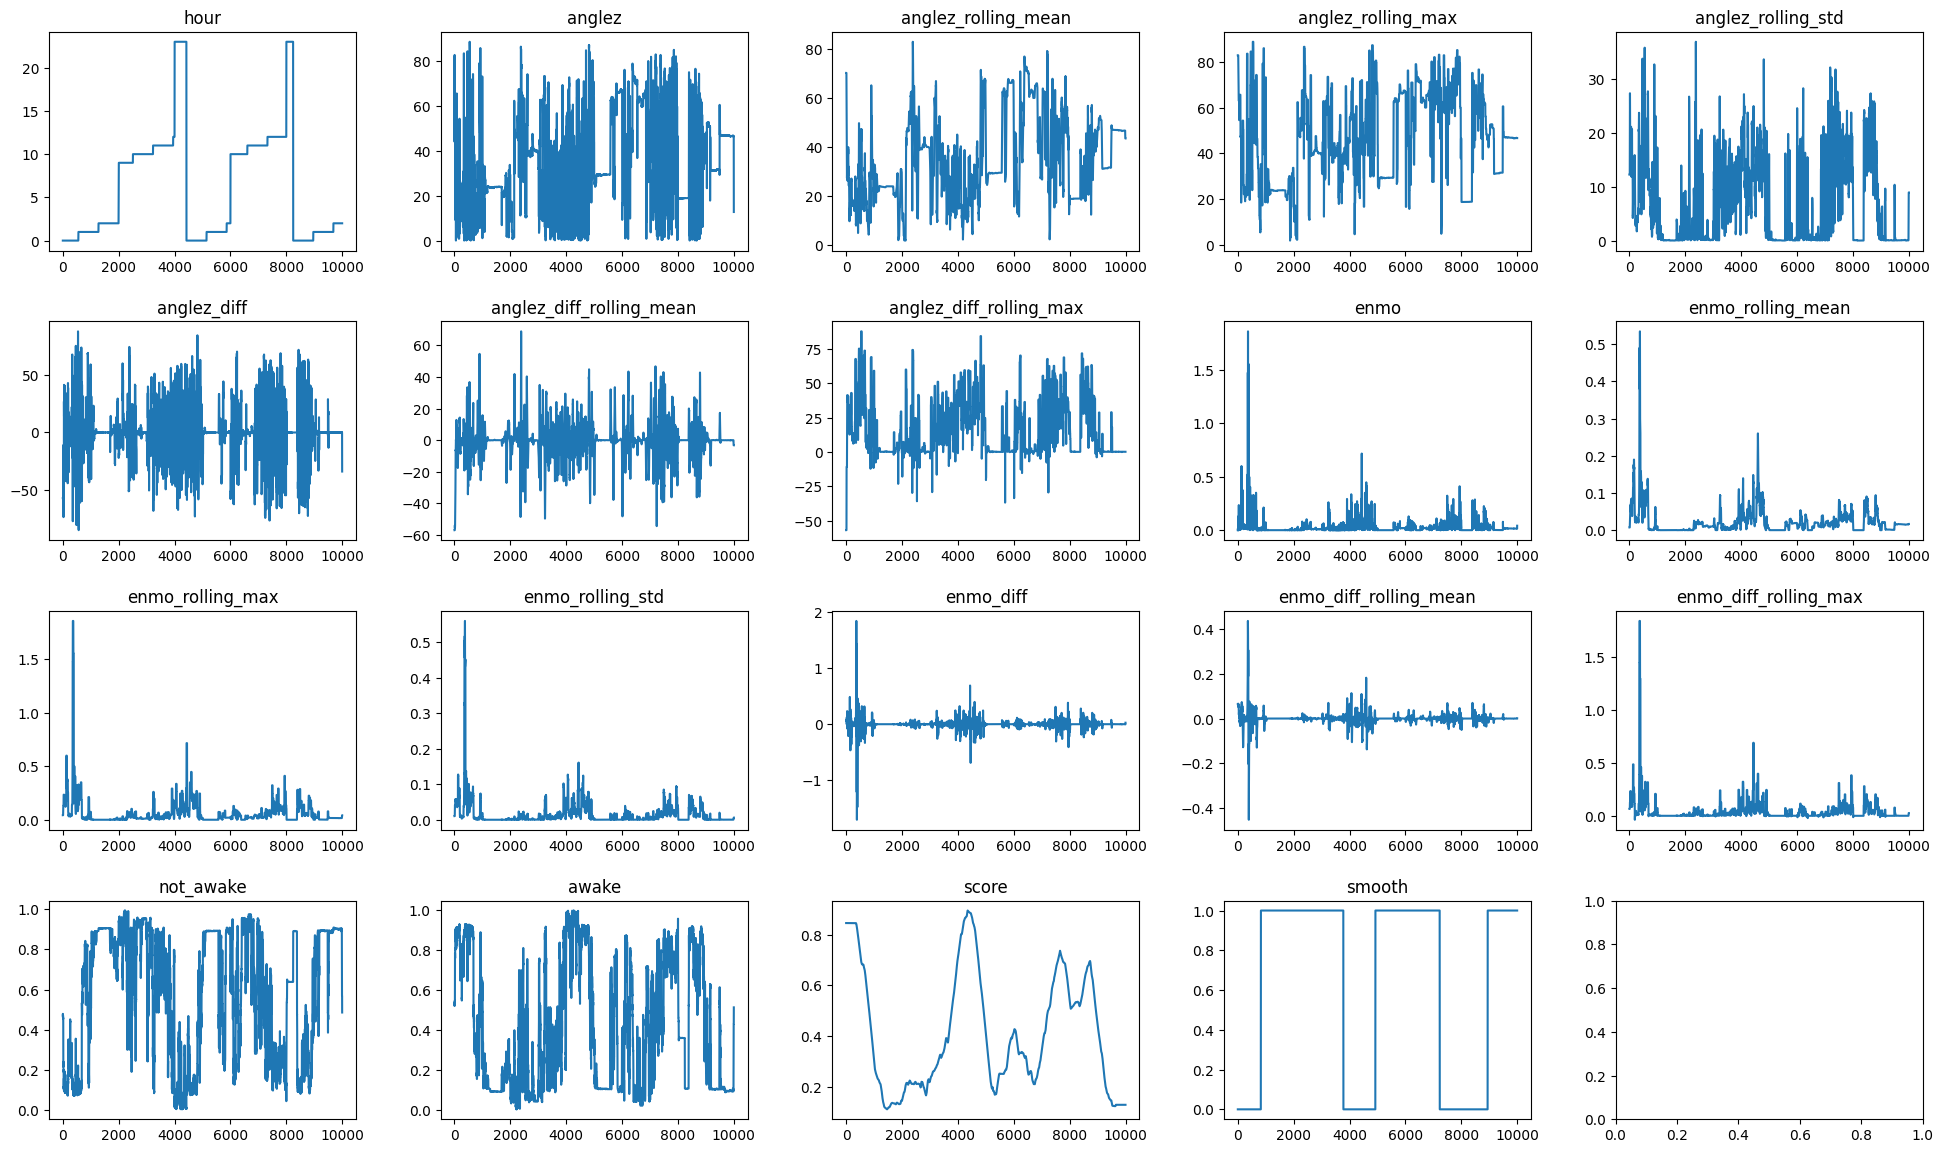

In [79]:
# Danh sách các tính năng
features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
            "not_awake",
            "awake",
            "score",
            "smooth"
           ]

sample_num = test.shape[0]

# Tạo subplot
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
fig.tight_layout(pad=3.0)  # Để tránh trùng lấn giữa các subplot

# Lặp qua danh sách các tính năng và vẽ chúng
for i, feature in enumerate(features):
    row = i // 5  # Xác định hàng cho subplot
    col = i % 5   # Xác định cột cho subplot
    ax = axes[row, col]  # Lấy subplot tại vị trí hàng và cột

    # Vẽ tính năng hiện tại
    ax.plot(range(sample_num), test[feature])
    ax.set_title(feature)  # Đặt tiêu đề cho subplot

plt.show()